In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

Load Data

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DT-Credit.csv')

In [4]:
df.head()

,Income,Limit,Rating,Cards,Age,Education,Own,Student,Married,Region,Balance
0,14.891,3606,283,2,34,11,No,No,Yes,South,333
1,106.025,6645,483,3,82,15,Yes,Yes,Yes,West,903
2,104.593,7075,514,4,71,11,No,No,No,West,580
3,148.924,9504,681,3,36,11,Yes,No,No,West,964
4,55.882,4897,357,2,68,16,No,No,Yes,South,331


In [5]:
df.shape

(400, 11)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Income     400 non-null    float64
 1   Limit      400 non-null    int64  
 2   Rating     400 non-null    int64  
 3   Cards      400 non-null    int64  
 4   Age        400 non-null    int64  
 5   Education  400 non-null    int64  
 6   Own        400 non-null    object 
 7   Student    400 non-null    object 
 8   Married    400 non-null    object 
 9   Region     400 non-null    object 
 10  Balance    400 non-null    int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 34.5+ KB


In [7]:
df.describe()

,Income,Limit,Rating,Cards,Age,Education,Balance
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,45.218885,4735.600000,354.940000,2.957500,55.667500,13.450000,520.015000
std,35.244273,2308.198848,154.724143,1.371275,17.249807,3.125207,459.758877
min,10.354000,855.000000,93.000000,1.000000,23.000000,5.000000,0.000000
25%,21.007250,3088.000000,247.250000,2.000000,41.750000,11.000000,68.750000
50%,33.115500,4622.500000,344.000000,3.000000,56.000000,14.000000,459.500000
75%,57.470750,5872.750000,437.250000,4.000000,70.000000,16.000000,863.000000
max,186.634000,13913.000000,982.000000,9.000000,98.000000,20.000000,1999.000000


In [8]:
df.isnull().sum()

,0
Income,0
Limit,0
Rating,0
Cards,0
Age,0
Education,0
Own,0
Student,0
Married,0
Region,0


Separate categorical and numerical columns

In [9]:
un = df['Own'].unique()
print(un)

['No' 'Yes']


In [10]:
un = df['Student'].unique()
print(un)

['No' 'Yes']


In [11]:
un = df['Region'].unique()
print(un)

['South' 'West' 'East']


In [12]:
un = df['Married'].unique()
print(un)

['Yes' 'No']


In [13]:
categorical = df.select_dtypes(include=['object']).columns
numerical = df.select_dtypes(exclude=['object']).columns


One-hot encode for categorical features

In [14]:
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_data = encoder.fit_transform(df[categorical])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical))
encoded_df.index = df.index


In [15]:
df = df.drop(categorical, axis=1)
df = pd.concat([df, encoded_df], axis=1)


In [16]:
X = df.drop(columns=['Balance'])
y = df['Balance']

In [17]:
X.head()

,Income,Limit,Rating,Cards,Age,Education,Own_Yes,Student_Yes,Married_Yes,Region_South,Region_West
0,14.891,3606,283,2,34,11,0.0,0.0,1.0,1.0,0.0
1,106.025,6645,483,3,82,15,1.0,1.0,1.0,0.0,1.0
2,104.593,7075,514,4,71,11,0.0,0.0,0.0,0.0,1.0
3,148.924,9504,681,3,36,11,1.0,0.0,0.0,0.0,1.0
4,55.882,4897,357,2,68,16,0.0,0.0,1.0,1.0,0.0


In [18]:
X.shape

(400, 11)

In [19]:
corr = df.corr()

target = corr['Balance'].sort_values(ascending=False)

print("Correlation of each feature with the target variable (Balance):")
print(target)

Correlation of each feature with the target variable (Balance):
Balance         1.000000
Rating          0.863625
Limit           0.861697
Income          0.463656
Student_Yes     0.259018
Cards           0.086456
Own_Yes         0.021474
Age             0.001835
Region_South   -0.003288
Married_Yes    -0.005673
Education      -0.008062
Region_West    -0.009812
Name: Balance, dtype: float64


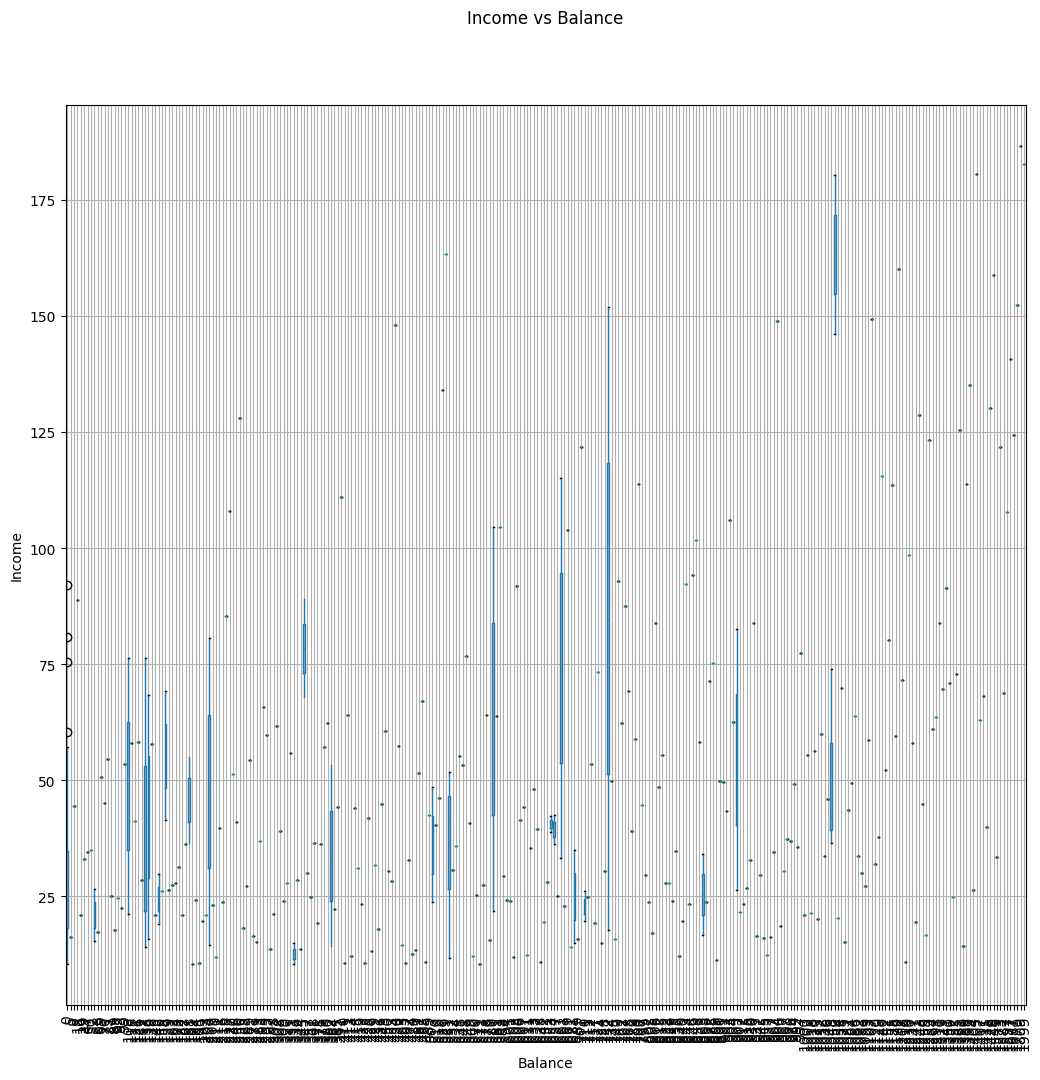

In [20]:
fig, ax = plt.subplots(1,1, figsize=(12, 12))
df.boxplot('Income', 'Balance', ax=ax)
plt.suptitle('Income vs Balance')
plt.title('')
plt.ylabel('Income')
plt.xticks(rotation=90)
plt.show()

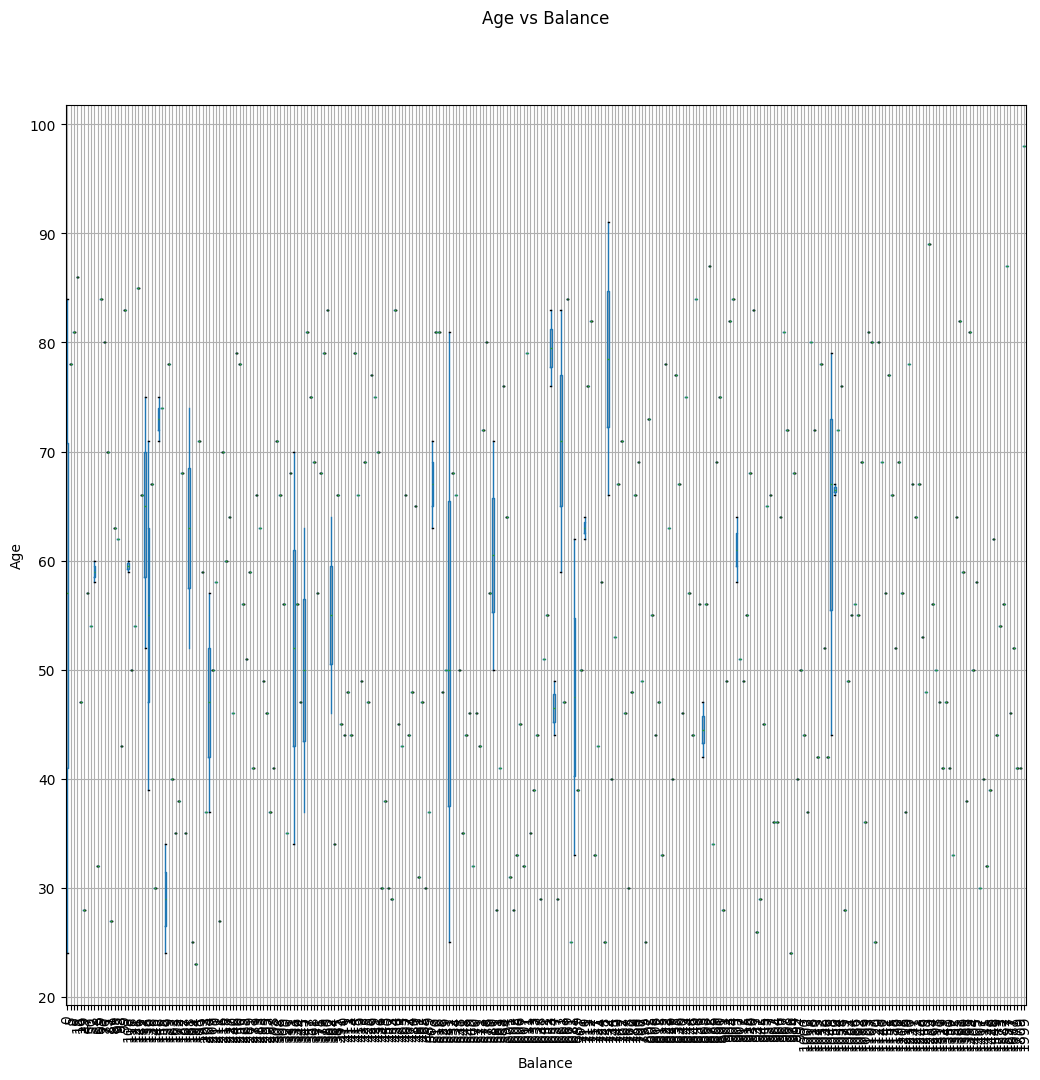

In [21]:
fig, ax = plt.subplots(1,1, figsize=(12, 12))
df.boxplot('Age', 'Balance', ax=ax)
plt.suptitle('Age vs Balance')
plt.title('')
plt.ylabel('Age')
plt.xticks(rotation=90)
plt.show()

Standardize features

In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Split data: 70% train, 15% validate, 15% test

In [23]:
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [24]:
X_train.shape

(280, 11)

In [25]:
X_val.shape

(60, 11)

In [26]:
X_test.shape

(60, 11)

hyperparameter tuning

In [27]:
param_grid = {
    'max_depth': [3, 5, 7, 10,12, None],
    'min_samples_split': [2, 5, 10,12],
    'min_samples_leaf': [1, 2, 5,7],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
}


DecisionTreeRegressor

In [28]:
model = DecisionTreeRegressor(random_state=42)

Initialize GridSearchCV

In [29]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')


Fit Data

In [30]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'friedman_mse',
                                       'absolute_error'],
                         'max_depth': [3, 5, 7, 10, 12, None],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 5, 7],
                         'min_samples_split': [2, 5, 10, 12]},
             scoring='neg_mean_squared_error', verbose=2)

In [31]:
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'criterion': 'absolute_error', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [32]:
best_model = grid_search.best_estimator_

Predict and Evaluate the performance

In [33]:
y_train_pred = best_model.predict(X_train)
y_val_pred = best_model.predict(X_val)
y_test_pred = best_model.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_val = mean_squared_error(y_val, y_val_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_val, y_val_pred)
r2_test = r2_score(y_test, y_test_pred)

print("Mean Squared Error (Train):", mse_train)
print("Mean Squared Error (Validation):", mse_val)
print("Mean Squared Error (Test):", mse_test)
print("R² (Train): {:.2f}".format(r2_train))
print("R² (Validation): {:.2f}".format(r2_val))
print("R² (Test): {:.2f}".format(r2_test))


Mean Squared Error (Train): 1958.2410714285713
Mean Squared Error (Validation): 13894.1875
Mean Squared Error (Test): 31474.529166666667
R² (Train): 0.99
R² (Validation): 0.94
R² (Test): 0.79


## Using XGBOOSTER

In [34]:
from xgboost import XGBRegressor

In [35]:
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

XGBoost hyperparameter tuning

In [36]:
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}


In [37]:
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

In [38]:
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 7, 10],
                         'min_child_weight': [1, 3, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='neg_mean_squared_error', verbose=2)

In [39]:
best_params = grid_search.best_params_
print("Best Parameters:", best_params)


Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.6}


performance of xgboost

In [40]:
best_model = grid_search.best_estimator_

y_train_pred = best_model.predict(X_train)
y_val_pred = best_model.predict(X_val)
y_test_pred = best_model.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_val = mean_squared_error(y_val, y_val_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_val, y_val_pred)
r2_test = r2_score(y_test, y_test_pred)

print("Mean Squared Error (Train):", mse_train)
print("Mean Squared Error (Validation):", mse_val)
print("Mean Squared Error (Test):", mse_test)
print("R² (Train): {:.2f}".format(r2_train))
print("R² (Validation): {:.2f}".format(r2_val))
print("R² (Test): {:.2f}".format(r2_test))


Mean Squared Error (Train): 1524.1524163943013
Mean Squared Error (Validation): 6026.204010038105
Mean Squared Error (Test): 7068.067346439898
R² (Train): 0.99
R² (Validation): 0.97
R² (Test): 0.95


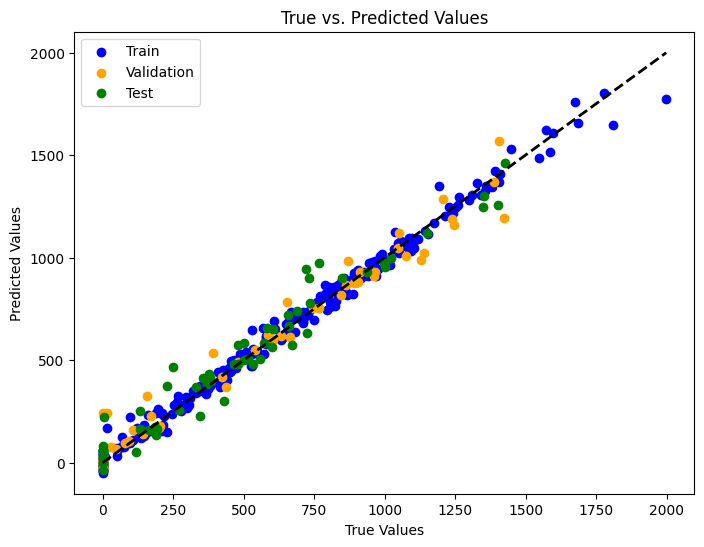

In [41]:
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_train_pred, color="blue", label="Train")
plt.scatter(y_val, y_val_pred, color="orange", label="Validation")
plt.scatter(y_test, y_test_pred, color="green", label="Test")
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs. Predicted Values")
plt.legend()
plt.show()

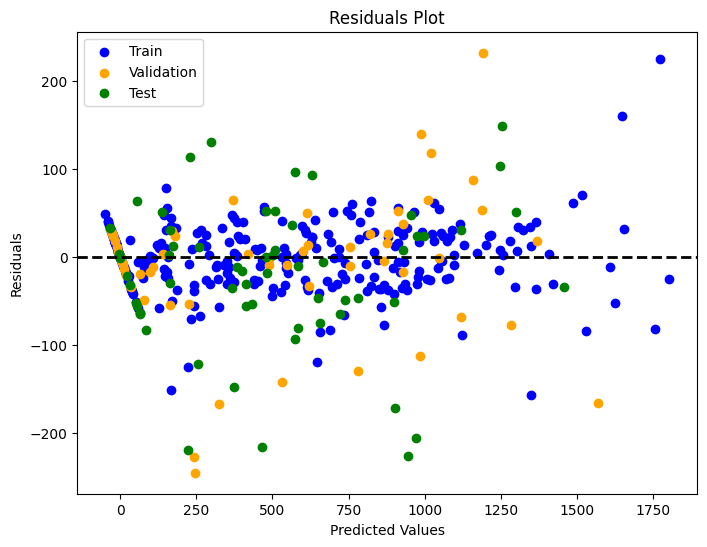

In [42]:
train_residuals = y_train - y_train_pred
val_residuals = y_val - y_val_pred
test_residuals = y_test - y_test_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_train_pred, train_residuals, color="blue", label="Train")
plt.scatter(y_val_pred, val_residuals, color="orange", label="Validation")
plt.scatter(y_test_pred, test_residuals, color="green", label="Test")
plt.axhline(0, color="black", linestyle="--", linewidth=2)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.legend()
plt.show()
